# Logistic Regression

For classification, linear regression is not the right approach as it will give too much weight to data far from the decision frontier. A linear approach is to fit a sigmoid function or logistic function:
$$y = \frac{1}{1+e^{-X\beta + \alpha}} + \epsilon$$ 

[![Logistic Regression](http://img.youtube.com/vi/zAULhNrnuL4/0.jpg)](https://www.youtube.com/watch?v=zAULhNrnuL4)

# [Simple example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [7]:
# this is our test set, it's just a straight line with some
# random normally distributed noise
xmin, xmax = -5, 5
n_samples = 100
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0).astype(np.float)
X[X > 0] *= 4
X += .3 * np.random.normal(size=n_samples)
X = X[:, np.newaxis]

In [8]:
# run the classifier
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

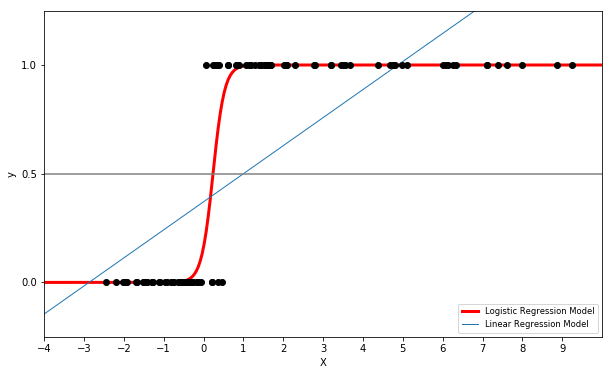

In [11]:
# and plot the result
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

loss = sigmoid(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)

# lets show the linear regression model for comparison
ols = linear_model.LinearRegression()
ols.fit(X, y)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
plt.axhline(.5, color='.5')

# labelling is always good
plt.ylabel('y')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="lower right", fontsize='small')
plt.show()

# Logistic Regression on the MBTI dataset

In [15]:
import numpy as np
import pandas as pd

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

import nltk

## Getting the data

Most of this analysis was covered in the previous tutorial. Head back there if you need a refresher.

In [16]:
## read the data
mbti = pd.read_csv('../7_Data/mbti_1.csv')

In [17]:
## split the rows
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

In [18]:
all_mbti.head()

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [19]:
## remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [20]:
# make lower case
all_mbti['post'] = all_mbti['post'].str.lower()

In [21]:
import string
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
all_mbti['post'] = all_mbti['post'].apply(remove_punctuation_numbers)

In [22]:
all_mbti.head()

,type,post
0,INFJ,urlweb
1,INFJ,urlweb
2,INFJ,enfp and intj moments urlweb sportscenter no...
3,INFJ,what has been the most lifechanging experience...
4,INFJ,urlweb urlweb on repeat for most of today


In [23]:
sum_mbti = all_mbti[['type', 'post']].groupby('type').count()

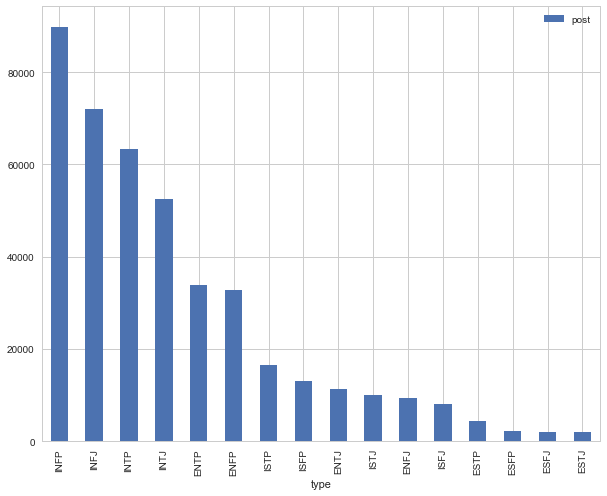

In [24]:
sum_mbti.sort_values('post', ascending=False).plot(kind='bar')

## Create the Predictor Variables

In [25]:
# List of mbti types 
type_labels = ['ISTJ', 'ISFJ', 'INFJ', 'INTJ', 
               'ISTP', 'ISFP', 'INFP', 'INTP', 
               'ESTP', 'ESFP', 'ENFP', 'ENTP', 
               'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ']

We want to check for Introverts versus extroverts.  lets create an indicator variables based on the type

In [26]:
all_mbti['I'] = all_mbti['type'].apply(lambda x: x[0] == 'I').astype('int')

In [27]:
all_mbti.head()

,type,post,I
0,INFJ,urlweb,1
1,INFJ,urlweb,1
2,INFJ,enfp and intj moments urlweb sportscenter no...,1
3,INFJ,what has been the most lifechanging experience...,1
4,INFJ,urlweb urlweb on repeat for most of today,1


In [28]:
all_mbti.groupby('type').sum()

,I
type,
ENFJ,0
ENFP,0
ENTJ,0
ENTP,0
ESFJ,0
ESFP,0
ESTJ,0
ESTP,0
INFJ,72105


## Benchmark if we guessed randomly we should at least

We will checkhow good our model is based on a VERY naive model - which assumes that all entries are written by introverts!  This result means that our model has to be more than 77% accurate for us to be onto something here...

In [32]:
np.mean(all_mbti['I'] == 1)

0.76922512977568613

## Creating the dataset for the ML Algorithms

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
# we will be using the standard CountVector to fit the model to see if we can indeed predit the 
vect = CountVectorizer()
X_count = vect.fit_transform(all_mbti['post'])

In [37]:
X_count.shape

(422845, 144816)

There should already be alarm bells sounding here.  We have more than 422,000 rows, which is enough data for this algoritm to run effectively.  We, however,  have almost 145,000 features - alot of which correspond to words which only appear once.  

For this tutorial, we will be using the top 10 words that appear most often, just so that we can demonstrate how to interpret a logistic regrssion model. Don't worry too much about this step, we will be covering hyperparameter tuning in the next couple of tutorials.

In [43]:
vect_10 = CountVectorizer(lowercase=True, stop_words='english', max_features=10)
X_count = vect_10.fit_transform(all_mbti['post'])

In [44]:
X_count.shape

(422845, 10)

In [45]:
vect_10.get_feature_names()

['dont',
 'im',
 'ive',
 'just',
 'know',
 'like',
 'people',
 'really',
 'think',
 'urlweb']

## Setting up the train_test_split

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [61]:
X = X_count

In [62]:
y = all_mbti['I']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Training the logistic regression model

In [88]:
logreg = LogisticRegression()

In [89]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Checking outcomes on the training set

### Overall Accuracy Score

Overall accuracy is the percentage of times we predict the correct class in the data.

#### Training data

In [90]:
from sklearn import metrics

In [91]:
# generate predictions
y_pred_train = logreg.predict(X_train)

In [92]:
# calculating the accuracy manually
np.mean(y_pred_train == y_train)

0.76962031702787159

In [93]:
# or using sklearn.metrics inbuilt classification metric
metrics.accuracy_score(y_train, y_pred_train)

0.76962031702787159

#### Testing data

In [98]:
# generate predictions
y_pred_test = logreg.predict(X_test)
metrics.accuracy_score(y_test, y_pred_test)

0.76803957923414556

So our model does not do much better than prediciting everyone is introverted!  Let's see if we can see whats going on....

### [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing. (Thanks [DataSchool](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) for the help in explaining!)

Let's now define the most basic terms, which are whole numbers (not rates):

* true positives (TP): These are cases in which we predicted yes (we think an introvert wrote this), and they are indeed an introvert.
* true negatives (TN): We predicted no (not introverted), and they are not introverted.
* false positives (FP): We predicted yes (introverted), but they are actually extroverted (Also known as a "Type I error.")
* false negatives (FN): We predicted no (not introverted), but they are actually introverted. (Also known as a "Type II error.")

This gives the following generic confusion matrix:
![Confusion](./lr/confusion.png)

So let's look at the confusion martix for our current model...

In [133]:
metrics.confusion_matrix(y_train, y_pred_train)

array([[     0,  73061],
       [     0, 244072]])

So our model is essentially predicting everyone is introverted! Let's see what going on...

### Probability predictions

In [132]:
pred_prob = logreg.predict_proba(X_train)
pred_prob[0:10]

array([[ 0.23420322,  0.76579678],
       [ 0.23599147,  0.76400853],
       [ 0.23354278,  0.76645722],
       [ 0.22100146,  0.77899854],
       [ 0.23778913,  0.76221087],
       [ 0.23420322,  0.76579678],
       [ 0.22009023,  0.77990977],
       [ 0.22733482,  0.77266518],
       [ 0.21225903,  0.78774097],
       [ 0.23420322,  0.76579678]])

Okay, so the model is predicting different probabilites for each observation, but they are clustered close to 77% becuase of all the Introverts in the data. All of these are being classified as Introverts because the sklearn descision threshold is set to 50%.  Therefore any prediction greater than 50% is being classifed as an Introvert (in this case all of them!)

So what are we to do?  We have two options now:
* Increase the decision threshold so that it will classify 77% of the observations as introverted, or
* Re-create the test set so that there are an equal number of introverts and extroverts

#### Increasing the threshold

First, we need to find the threshold prediction that gives us 77% introverts, or 23% non-introverts

In [128]:
threshold = np.percentile(pred_prob[:,1], 23,)
threshold

0.7623528734440993

Any prediction above 76.2% will therefore now be classified as introverted

In [131]:
y_train_pred_threshold = (pred_prob[:,1] > threshold).astype(int)
np.mean(y_train_pred_threshold)

0.76953517924656212

In [135]:
metrics.confusion_matrix(y_train, y_train_pred_threshold)

array([[ 17608,  55453],
       [ 55480, 188592]])

At least we are getting some non extroverts coming through now!  This method has a significant disadvantage though! Using the percentile to set the threshold, meand that your accuracy on the training data can never be better than a naive estimate!

How does it perform out of sample though?

In [136]:
pred_prob_test = logreg.predict_proba(X_test)
y_test_pred_threshold = (pred_prob_test[:,1] > threshold).astype(int)
np.mean(y_test_pred_threshold)

0.77266535492659305

### [Classification reports](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

The Classification Report gives us more information on where our model is going wrong - looking specifically at the performance caused by Type I & II errors.  The following metrics are calculated as part of the classification report. 
* Precision = When it predicts yes, how often is it correct? Formally, $ Precision = \frac{True Positive}{Predicted Positive} $
* Recall = When the outcome is actually True, how often do we predict it so? Formally, $ Recall = \frac{True Positive}{Condition True}$
* [F1 score](https://en.wikipedia.org/wiki/F1_score) = weighted average of Precision and Recall. Formally, $F_1 = 2 \times \frac {precision \times recall }{precision + recall }$

In [138]:
from sklearn.metrics import classification_report

In [143]:
print(classification_report(y_train, y_train_pred_threshold, target_names=['Extroverted', 'Introverted']))

             precision    recall  f1-score   support

Extroverted       0.24      0.24      0.24     73061
Introverted       0.77      0.77      0.77    244072

avg / total       0.65      0.65      0.65    317133



### Is it because the data is unbalanced? 

Another approach would be to rebalance the data to give us an even number of positives and negatives.  For logistic regression models, unbalanced training data affects only the estimate of the model intercept (although this of course skews all the predicted probabilities, which in turn compromises your predictions) (thanks [conjugateprior](https://stats.stackexchange.com/questions/6067/does-an-unbalanced-sample-matter-when-doing-logistic-regression)!)

## Where to from here?

Turns out our first model is not very good!  Don't be discouraged as our first attempt never usually is! Generally, there are a couple of methods to try and improve our model:
* Improve the data & feature set
* Try another algorithm
* Fine tune the algorithm parameters

Why don't you have a chatplay around with trying to make this model better?

# Further Reading

http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf

https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a

http://www.data-mania.com/blog/logistic-regression-example-in-python/

http://www.dataschool.io/roc-curves-and-auc-explained/